**Проект e-commerce**  
Необходимо проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Стоит учесть, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно помнить.  

5. Провести когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

6. Построить RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Для каждого RFM-сегмента построить границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Файлы:

**olist_customers_datase.csv** — таблица с уникальными идентификаторами пользователей  

*customer_id* — позаказный идентификатор пользователя

*customer_unique_id* —  уникальный идентификатор пользователя  (аналог номера паспорта)

*customer_zip_code_prefix* —  почтовый индекс пользователя

*customer_city* —  город доставки пользователя

*customer_state* —  штат доставки пользователя

**olist_orders_dataset.csv** —  таблица заказов  

*order_id* —  уникальный идентификатор заказа (номер чека)

*customer_id* —  позаказный идентификатор пользователя

*order_status* —  статус заказа

*order_purchase_timestamp* —  время создания заказа

*order_approved_at* —  время подтверждения оплаты заказа

*order_delivered_carrier_date* —  время передачи заказа в логистическую службу

*order_delivered_customer_date* —  время доставки заказа

*order_estimated_delivery_date* —  обещанная дата доставки

**olist_order_items_dataset.csv** —  товарные позиции, входящие в заказы  

*order_id* —  уникальный идентификатор заказа (номер чека)

*order_item_id* —  идентификатор товара внутри одного заказа

*product_id* —  ид товара (аналог штрихкода)

*seller_id* — ид производителя товара

*shipping_limit_date* —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

*price* —  цена за единицу товара

*freight_value* —  вес товара


Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан  
approved —  подтверждён  
invoiced —  выставлен счёт  
processing —  в процессе сборки заказа  
shipped —  отгружен со склада  
delivered —  доставлен пользователю  
unavailable —  недоступен  
canceled —  отменён

In [165]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [166]:
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')

In [167]:
display(customers.dtypes, orders.dtypes, order_items.dtypes)

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [168]:
# распарсим даты
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=[3, 4, 5, 6, 7])
order_items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=[4])
display(customers.dtypes, orders.dtypes, order_items.dtypes)

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [169]:
# смотрим размерности ДФ
print(f'Размерность таблицы пользователей (customers) {customers.shape}')
print(f'Размерность таблицы заказов (orders) {orders.shape}')
print(f'Размерность таблицы товарных позиций (order_items) {order_items.shape}')

Размерность таблицы пользователей (customers) (99441, 5)
Размерность таблицы заказов (orders) (99441, 8)
Размерность таблицы товарных позиций (order_items) (112650, 7)


In [170]:
# кол-во уникальных customer
customers.customer_unique_id.nunique()

96096

In [171]:
# кол-во уникальных order_id в таблицах orders и order_items
print(f'Кол-во уникальных order_id в orders {orders.order_id.nunique()}')
print(f'Кол-во уникальных order_id в order_items {order_items.order_id.nunique()}')

Кол-во уникальных order_id в orders 99441
Кол-во уникальных order_id в order_items 98666


In [172]:
# единственная таблица с Nan - orders
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [173]:
# проверяем дату оплаты и доставки с разбивкой по статусам
orders.groupby('order_status') \
    .agg({'order_id': 'count', 'order_approved_at': 'count', 'order_delivered_customer_date': 'count'})

,order_id,order_approved_at,order_delivered_customer_date
order_status,,,
approved,2,2,0
canceled,625,484,6
created,5,0,0
delivered,96478,96464,96470
invoiced,314,314,0
processing,301,301,0
shipped,1107,1107,0
unavailable,609,609,0


Дата доставки есть только у заказов со статусами *delivered* и *canceled*. Заказы со статусом *canceled* возможно были отменены после доставки, отсеиваем эти заказы. Не все заказы со статусом *delivered* имеют дату подтверждения платежа и доставки. Такие заказы тоже придется отбросить.  
Итог: берем заказы со статусом *delivered*, у которых есть дата подтверждения платежа и дата доставки.

In [174]:
# берем заказы со статусом delivered, у которых есть дата платежа и доставки
# это будет наша таблица с покупками
buy_orders = orders.query('order_status == "delivered" and (not order_approved_at.isna()) and (not order_delivered_customer_date.isna())')

In [175]:
buy_orders.shape

(96456, 8)

In [176]:
# проверим есть ли в buy_orders заказы, отсутствующие в order_items

print(f'Кол-во уникальных order_id в buy_orders {buy_orders.order_id.nunique()}')
print(f'Кол-во уникальных order_id в order_items {order_items.order_id.nunique()}')

# кол-во order_id, которые есть в buy_orders и нет в order_items
only_orders_id = buy_orders.query('order_id not in @order_items.order_id').order_id.nunique()

# кол-во order_id, которые есть в order_items и нет в orders
only_order_items_id = order_items.query('order_id not in @buy_orders.order_id').order_id.nunique()

print(f'Информация о {only_orders_id} заказов из таблицы buy_orders отсутствует в таблице order_items')
print(f'Информация о {only_order_items_id} заказов из таблицы order_items отсутствует в таблице buy_orders')

Кол-во уникальных order_id в buy_orders 96456
Кол-во уникальных order_id в order_items 98666
Информация о 0 заказов из таблицы buy_orders отсутствует в таблице order_items
Информация о 2210 заказов из таблицы order_items отсутствует в таблице buy_orders


Все заказы из **buy_orders** есть в **order_items**. А в **order_items** есть заказы, отсутствующие в **buy_orders**, поскольку мы отсеили некоторое кол-во заказов.

### Задача 1

Сколько у нас пользователей, которые совершили покупку только один раз?

In [177]:
# объединяем таблицу с покупками с таблицей с идентификаторами пользователей
buy_customers = buy_orders.merge(customers, on='customer_id')

In [178]:
buy_customers.shape

(96456, 12)

Кол-во сторок осталось такое же, как в **buy_orders** - мы ничего не потеряли.

In [179]:
buy_customers.order_id.nunique()

96456

In [180]:
# группируем по уникальным пользователям, считаем уникальные order_id,
# отбираем пользователей с 1 покупкой, считаем кол-во
customer_1_buy = buy_customers.groupby('customer_unique_id', as_index=False) \
    .agg({'order_id': 'nunique'}) \
    .query('order_id == 1') \
    .order_id.count()

# общее кол-во пользователей, совершавших покупки
count_customers = buy_customers.customer_unique_id.nunique()

# процент пользователей, совершивших 1 покупку
percent_1_buy = np.multiply(customer_1_buy / count_customers, 100).round(2)

print(f'Кол-во пользователей, совершивших 1 покупку {customer_1_buy}.')
print(f'Что составляет {percent_1_buy}% от числа покупавших пользователей.')

Кол-во пользователей, совершивших 1 покупку 90537.
Что составляет 97.0% от числа покупавших пользователей.


### Задача 2

Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?  
В качестве причины не доставленных заказов будет использовать статусы *canceled* и *unavailable*

In [181]:
# создаем копию orders и берем заказы со статусами canceled и unavailable
orders_bad_status = orders.copy().query('order_status == "canceled" or order_status == "unavailable"')

In [182]:
# создаем столбец формата 'yyyy-mm'
orders_bad_status['month'] = orders_bad_status['order_purchase_timestamp'].dt.to_period('M')
orders_bad_status.month.unique()

<PeriodArray>
['2017-11', '2018-08', '2018-01', '2017-08', '2017-09', '2018-09', '2018-05',
 '2018-07', '2017-03', '2017-07', '2017-05', '2017-06', '2018-04', '2017-02',
 '2017-10', '2018-02', '2016-10', '2018-06', '2017-12', '2017-01', '2016-09',
 '2018-03', '2017-04', '2018-10']
Length: 24, dtype: period[M]

In [183]:
# берем заказы с отсутствующей датой доставки, группируем по месяцу и статусу, считаем кол-во заказов
no_delivery_date = orders_bad_status.query('order_delivered_customer_date.isna()') \
    .groupby(['month', 'order_status'], as_index=False) \
    .agg({'order_id': 'count'})
no_delivery_date.head()

,month,order_status,order_id
0,2016-09,canceled,2
1,2016-10,canceled,19
2,2016-10,unavailable,7
3,2017-01,canceled,3
4,2017-01,unavailable,10


In [184]:
# группируем по статусу и считаем среднее кол-во заказов
no_delivery_date.groupby('order_status') \
    .agg({'order_id': 'mean'})

,order_id
order_status,
canceled,25.791667
unavailable,29.000000


In [185]:
no_delivery_date.order_status.value_counts()

canceled       24
unavailable    21
Name: order_status, dtype: int64

Поскольку не в каждом месяце присутствуют заказы со всеми возможными статусами, мы получим искаженные средние.

In [186]:
avg_day_in_month = 365 / 12   # возьмем среднее кол-во дней в месяце

# посчитаем кол-во дней от первого заказа до последнего
days = (orders_bad_status.order_purchase_timestamp.max() - orders_bad_status.order_purchase_timestamp.min()).days

month = days / avg_day_in_month   # и разделим на кол-во дней в месяце
month   # получим кол-во месяцев в наших наблюдениях

25.38082191780822

In [187]:
# берем заказы с отсутствующей датой доставки, группируем по статусу,
# считаем кол-во заказов и делим на число месяцев
no_delivery = orders_bad_status.query('order_delivered_customer_date.isna()') \
    .groupby('order_status') \
    .agg({'order_id': 'count'}) / month
no_delivery

,order_id
order_status,
canceled,24.388493
unavailable,23.994495


In [188]:
# присваиваем переменным значения кол-ва не доставленных заказов
canceled = no_delivery.loc['canceled', 'order_id']
unavailable = no_delivery.loc['unavailable', 'order_id']

print(f'В среднем в месяц не доставляются из-за отмены заказа {np.round(canceled, 2)} заказов')
print(f'В среднем в месяц не доставляются из-за потери заказа {np.round(unavailable, 2)} заказов')

В среднем в месяц не доставляются из-за отмены заказа 24.39 заказов
В среднем в месяц не доставляются из-за потери заказа 23.99 заказов


### Задача 3

По каждому товару определить, в какой день недели товар чаще всего покупается.

In [189]:
# создадим таблицу покупок с детализацией
# объединяем таблицы покупок и детализации заказов
buy_orders_items = buy_orders.merge(order_items, on='order_id')

In [190]:
# кол-во уникальных товаров в таблице покупок с детализацией
first_product_id = buy_orders_items.product_id.nunique()
first_product_id

32211

In [191]:
buy_orders_items.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           float64
dtype: object

In [192]:
# преобразуем колонку order_purchase_timestamp в формат datetime
buy_orders_items['order_purchase_timestamp'] = pd.to_datetime(buy_orders_items['order_purchase_timestamp'])

In [193]:
# создаем новый столбец с днем недели покупки
# за день покупки берем день создания заказа order_purchase_timestamp
buy_orders_items['weekday'] = buy_orders_items.order_purchase_timestamp.dt.day_name()

In [194]:
# создадим дф с покупками каждого товара по дням недели
# группируем дф по product_id и дню недели, считаем кол-во заказов
weekday_count = buy_orders_items.groupby(['product_id', 'weekday'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'order_count'})   

In [195]:
# находим максимальное число покупок за день для каждого товара
max_order_count = weekday_count.groupby('product_id', as_index=False).agg({'order_count': 'max'})

In [196]:
# создадим результирующую таблицу
# объединяем таблицы с покупками по дням недели и максимальным числом покупок товара
max_weekday_buy = max_order_count.merge(weekday_count, on=['product_id', 'order_count'])
max_weekday_buy

,product_id,order_count,weekday
0,00066f42aeeb9f3007548bb9d3f33c38,1,Sunday
1,00088930e925c41fd95ebfe695fd2655,1,Tuesday
2,0009406fd7479715e4bef61dd91f2462,1,Thursday
3,000b8f95fcb9e0096488278317764d19,1,Friday
4,000b8f95fcb9e0096488278317764d19,1,Wednesday
...,...,...,...
41763,fff6177642830a9a94a0f2cba5e476d1,1,Sunday
41764,fff81cc3158d2725c0655ab9ba0f712c,1,Monday
41765,fff9553ac224cec9d15d49f5a263411f,1,Friday
41766,fffdb2d0ec8d6a61f0a0a0db3f25b441,2,Tuesday


In [197]:
# кол-во уникальных товаров в результирующей таблице
final_product_id = max_weekday_buy.product_id.nunique()

# проверим не потерялись ли товары
if first_product_id == final_product_id:
    print('ОК')

ОК


### Задача 4

Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?  
Стоит учесть, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно помнить.

Исползуем таблицу из 1 задания с покупками и идентификаторами пользователей **buy_customers**

In [198]:
buy_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [199]:
# создаем колонку с месяцем заказа
buy_customers['month'] = buy_customers.order_purchase_timestamp.dt.to_period('M')

# посчитаем кол-во покупок каждого пользователя в определенный месяц
# группируем по пользователям и месяцу, считаем кол-во покупок
buy_by_month = buy_customers.groupby(['customer_unique_id', 'month'], as_index=False) \
    .agg({'order_id': 'nunique'}) \
    .rename(columns={'order_id': 'order_count'})

# кол-во покупок каждого пользователя за определенный месяц
buy_by_month.head()

,customer_unique_id,month,order_count
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1
2,0000f46a3911fa3c0805444483337064,2017-03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1


In [200]:
# считаем кол-во дней в каждом месяце
buy_by_month['days'] = buy_by_month.month.apply(lambda x: x.days_in_month)
buy_by_month.head()

,customer_unique_id,month,order_count,days
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,31
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,31
2,0000f46a3911fa3c0805444483337064,2017-03,1,31
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,31
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,30


In [201]:
# делим кол-во покупок пользователя за месяц на число недель в месяце (кол-во дней / 7)
buy_by_month['purchase_by_week'] = buy_by_month.order_count / (buy_by_month.days / 7)
buy_by_month.head()

,customer_unique_id,month,order_count,days,purchase_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,31,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,31,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,1,31,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,31,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,30,0.233333


In [202]:
# результирующий ДФ без лишних колонок
mean_purchase_per_week_by_month = buy_by_month[['customer_unique_id', 'month', 'purchase_by_week']]
mean_purchase_per_week_by_month.sort_values('month').head()

,customer_unique_id,month,purchase_by_week
48804,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09,0.233333
79743,d60a512747263c5307fef65a58ff7532,2016-10,0.225806
22055,3b2aa495b3557acad84b380301a9cc94,2016-10,0.225806
81741,db890d2b3c871e8e4298f21bc8a7736b,2016-10,0.225806
82120,dc86b29986d1f8ad458040d2400bf941,2016-10,0.225806


### Задача 5

Провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.

Поскольку данные за весь год есть только в 2017, будем использовать его. Разделим на когорты пользователей, совершивших первую покупку в 2017 году.  
Используем таблицу из предыдущего шага с покупками пользователей по месяцам.

In [203]:
buy_by_month.head()

,customer_unique_id,month,order_count,days,purchase_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,31,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,31,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,1,31,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,31,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,30,0.233333


In [204]:
# уберем лишние колонки
buy_by_month_5 = buy_by_month.drop(['days', 'purchase_by_week'], axis=1)
buy_by_month_5.head()

,customer_unique_id,month,order_count
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1
2,0000f46a3911fa3c0805444483337064,2017-03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1


In [205]:
# для каждого пользователя определим месяц первой покупки
first_purchase = buy_by_month_5.groupby('customer_unique_id', as_index=False) \
    .agg({'month': 'min'}) \
    .rename(columns={'month': 'first_purchase'})

In [206]:
# добавим колонку с месяцем первой покупки в дф
buy_by_month_5 = buy_by_month_5.merge(first_purchase, on='customer_unique_id')
buy_by_month_5.head()

,customer_unique_id,month,order_count,first_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03,1,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,2017-11


In [207]:
# уберем информацию по ненужным месяцам
buy_by_month_period = buy_by_month_5 \
    .query('month >= "2017-01" and month <= "2018-03" and first_purchase >= "2017-01" and first_purchase <= "2017-12"')

Осталась информация о покупках, которые пользователи совершили впервые с января по декабрь, и о повторных покупках совершенных до марта следующего года включительно.

In [208]:
# создадим таблицу, сгруппированную по месяцу первой покупки и повторным покупкам в следующих месяцах
cohorts = buy_by_month_period.groupby(['first_purchase', 'month'], as_index=False) \
    .agg({'customer_unique_id': 'nunique'}) \
    .rename(columns={'customer_unique_id': 'purchases'})
cohorts.head()

,first_purchase,month,purchases
0,2017-01,2017-01,715
1,2017-01,2017-02,2
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3


In [209]:
# создадим дф с размером когорт
df_cohort_size = cohorts.groupby(['first_purchase'], as_index=False) \
    .agg({'purchases': 'max'}) \
    .rename(columns={'purchases': 'cohort_size'})
df_cohort_size.head()

,first_purchase,cohort_size
0,2017-01,715
1,2017-02,1616
2,2017-03,2503
3,2017-04,2256
4,2017-05,3450


In [210]:
# добавим размер когорт в нашу таблицу cohorts
cohorts = cohorts.merge(df_cohort_size, on='first_purchase')
cohorts.head()

,first_purchase,month,purchases,cohort_size
0,2017-01,2017-01,715,715
1,2017-01,2017-02,2,715
2,2017-01,2017-03,2,715
3,2017-01,2017-04,1,715
4,2017-01,2017-05,3,715


In [211]:
# удалим строки, где месяц равен месяцу первой покупки
cohorts = cohorts.query('first_purchase != month')

In [212]:
# сделаем преобразование таблицы, чтобы увидеть кол-во повторных покупок в последующих месяцах
cohorts.pivot(index=['first_purchase', 'cohort_size'], columns='month', values='purchases')

,month,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
first_purchase,cohort_size,,,,,,,,,,,,,,
2017-01,715,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0,3.0,1.0
2017-02,1616,NaN,3.0,5.0,2.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0
2017-03,2503,NaN,NaN,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0,9.0,3.0,5.0
2017-04,2256,NaN,NaN,NaN,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0
2017-05,3450,NaN,NaN,NaN,NaN,16.0,16.0,10.0,10.0,11.0,14.0,5.0,9.0,9.0,9.0
2017-06,3037,NaN,NaN,NaN,NaN,NaN,15.0,12.0,13.0,9.0,12.0,11.0,7.0,4.0,6.0
2017-07,3752,NaN,NaN,NaN,NaN,NaN,NaN,20.0,13.0,9.0,11.0,8.0,12.0,4.0,7.0
2017-08,4057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,14.0,11.0,14.0,21.0,12.0,11.0
2017-09,4004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,22.0,11.0,18.0,9.0,9.0


In [213]:
# добавим колонку с retention
cohorts['retention'] = cohorts.purchases / cohorts.cohort_size * 100
cohorts['n_month'] = cohorts['month'] - cohorts['first_purchase']
cohorts.head()

,first_purchase,month,purchases,cohort_size,retention,n_month
1,2017-01,2017-02,2,715,0.27972,<MonthEnd>
2,2017-01,2017-03,2,715,0.27972,<2 * MonthEnds>
3,2017-01,2017-04,1,715,0.13986,<3 * MonthEnds>
4,2017-01,2017-05,3,715,0.41958,<4 * MonthEnds>
5,2017-01,2017-06,1,715,0.13986,<5 * MonthEnds>


[Text(0.5, 23.52222222222222, 'Month'),
 Text(50.722222222222214, 0.5, 'Cohorts'),
 [],
 Text(0.5, 1.0, 'Cohort analysis')]

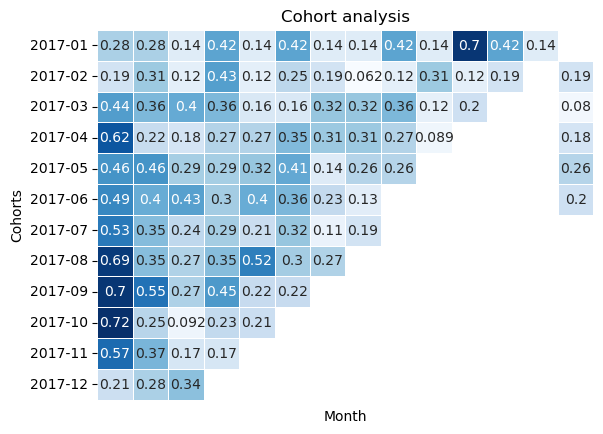

In [214]:
fig = sns.heatmap(cohorts.pivot('first_purchase', 'n_month', 'retention'), linewidths=.5, annot=True, cbar=False, cmap='Blues')
fig.set(xlabel='Month', ylabel='Cohorts', xticks=[], title='Cohort analysis')

Наибольший retention 3 месяца наблюдается у когорты пользователей, совершивших первую покупку в июне.

### Задача 6

Используя python, построить RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

Создадим таблицу покупок с детализацией заказов и информацией о пользователях. Для этого объединяем таблицы с покупками и идентификаторами пользователей `buy_customers` с таблицей детализации заказов `order_items`. Объединять будем inner по `order_id`, поскольку если у нас не будет информации о пользователе или о сумме заказа, то мы не сможем использовать такой заказ для сегментации пользователя. 

In [215]:
customers_orders_items = buy_customers.merge(order_items, on='order_id')
customers_orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


Проверим колонку `price`

In [216]:
order_items.sort_values('product_id').tail()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
17648,2878b4e373a9556df9aa1708a4e5c3c8,1,fffdb2d0ec8d6a61f0a0a0db3f25b441,9f505651f4a6abe901a56cdc21508025,2018-08-09 16:55:38,34.99,7.51
97508,dd38c566a34ff9deb93ff05d7bd6d0aa,1,fffdb2d0ec8d6a61f0a0a0db3f25b441,9f505651f4a6abe901a56cdc21508025,2018-05-07 17:53:01,34.99,7.39
83941,beaf95465b542dea76df78b2fb86a97a,1,fffdb2d0ec8d6a61f0a0a0db3f25b441,9f505651f4a6abe901a56cdc21508025,2018-04-25 10:30:35,34.99,18.23
94694,d6c1ed12e8eeaa15e9d5c83c79598f85,1,fffdb2d0ec8d6a61f0a0a0db3f25b441,9f505651f4a6abe901a56cdc21508025,2018-08-14 17:25:18,34.99,7.51
110888,fbf3da6fe82010412982890b0c57e532,1,fffe9eeff12fcbd74a2f2b007dde0c58,7299e27ed73d2ad986de7f7c77d919fa,2018-05-18 17:58:18,249.99,53.88


Видим, что товар `fffdb2d0ec8d6a61f0a0a0db3f25b441` продавался разным весом. Что это может значить:
1. Товар иногда (по акции) продается с дополнением по той же цене
2. Ошибка в данных
3. Цена `price` указана за единицу веса, что маловероятно, поскольку сложно представить, что товар продается на развес

Будем считать, что `price` - общая стоимость товара в заказе, и не будем производить никаках арифметических действий над ней.

In [217]:
customers_orders_items.describe()

,customer_zip_code_prefix,order_item_id,price,freight_value
count,110174.000000,110174.000000,110174.00000,110174.000000
mean,35156.118549,1.198214,119.97911,19.949005
std,29901.322278,0.706740,182.31334,15.699464
min,1003.000000,1.000000,0.85000,0.000000
25%,11310.000000,1.000000,39.90000,13.080000
50%,24344.000000,1.000000,74.90000,16.260000
75%,59066.000000,1.000000,134.17000,21.150000
max,99980.000000,21.000000,6735.00000,409.680000


Иногда вес товара вовсе не указывается. Значит версия об ошибке в данных находит подтверждение.

Теперь нужно сгруппировать дф и оставить только необходимые для анализа колонки: id заказа, id пользователя, дата и сумма покупки. Группировку будем проводить по 3 колонкам, а `price` суммировать.

In [218]:
# для этого создадим новый дф
cus_or_it = customers_orders_items.groupby(['order_id', 'order_purchase_timestamp', 'customer_unique_id'], as_index=False) \
    .agg({'price': 'sum'})
cus_or_it.head()

,order_id,order_purchase_timestamp,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.90
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,239.90
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,199.00
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,199.90


In [219]:
# определим дату, от которой будем считать время до последнего заказа(следующий день после последнего заказа в данных)
now = cus_or_it.order_purchase_timestamp.max() + pd.Timedelta(days=1)

In [220]:
# создадим колонку с кол-вом дней, прошедших с последнего заказа
cus_or_it['days_since_order'] = cus_or_it.order_purchase_timestamp.apply(lambda x: (now - x).days)

In [221]:
period = cus_or_it.days_since_order.max() - cus_or_it.days_since_order.min()
print(f'Мы наблюдаем данные за {period} дней')

Мы наблюдаем данные за 713 дней


In [222]:
cus_or_it.head()

,order_id,order_purchase_timestamp,customer_unique_id,price,days_since_order
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.90,351
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,239.90,491
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,199.00,228
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12.99,22
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,199.90,572


Теперь создадим RFM дф с id пользователя, кол-вом дней, прошедших с момента последнего заказа, кол-вом заказов и суммой покупок

In [223]:
# группируем по id пользователя и считаем нужные значения
rfm = cus_or_it.groupby('customer_unique_id', as_index=False) \
        .agg({'days_since_order': 'min',
             'order_id': 'nunique',
             'price': 'sum'}) \
        .rename(columns={'days_since_order': 'recency',
                        'order_id': 'frequency',
                        'price': 'monetary'})
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


In [224]:
# посмотрим описательную статистику наших данных
rfm.describe()

,recency,frequency,monetary
count,93337.000000,93337.000000,93337.000000
mean,237.904893,1.033417,141.622063
std,152.552478,0.209096,215.713022
min,1.000000,1.000000,0.850000
25%,114.000000,1.000000,47.650000
50%,219.000000,1.000000,89.700000
75%,346.000000,1.000000,154.700000
max,714.000000,15.000000,13440.000000


25% пользователей совершили последнюю покупку почти год назад, по monetary наблюдаются выбросы. Подавляющее большинство пользователей совершило только одну покупку - квантили по frequency не работают. Посчитаем кол-во пользователей по числу покупок.

In [225]:
rfm.frequency.value_counts().sort_values()

9         1
15        1
7         3
6         5
5         9
4        28
3       181
2      2572
1     90537
Name: frequency, dtype: int64

Исходя из наших данных, чтобы сегменты получились наиболее равномерными (насколько это возможно) в 5 сегмент frequency поместим пользователей, совершивших 5 и более покупок. Остальные сегменты распределим по числу покупок. `recency` и `monetary` распределим по квинтилям, чтобы в каждом сегменте было одинаковое кол-во пользователей.

In [226]:
# создадим словарь со значениями recency и monetary для каждого квинтиля
quintiles = rfm[['recency', 'monetary']].quantile([0.2, 0.4, 0.6, 0.8]).to_dict()
quintiles

{'recency': {0.2: 92.0, 0.4: 177.0, 0.6: 268.0, 0.8: 382.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

Создадим функции для распределения пользователей по сегментам R и M по квинтилям, F - по кол-ву покупок. Чем меньше значение `recency`, тем в более "лучший" сегмент попадет пользователь, для `monetary` - наоборот

In [227]:
def r_score(x):
    if x <= quintiles['recency'][0.2]:
        return 1
    elif x <= quintiles['recency'][0.4]:
        return 2
    elif x <= quintiles['recency'][0.6]:
        return 3
    elif x <= quintiles['recency'][0.8]:
        return 4
    else:
        return 5
    
def f_score(x):
    if x >= 5:
        return 5
    else:
        return x
    
def m_score(x):
    if x <= quintiles['monetary'][0.2]:
        return 1
    elif x <= quintiles['monetary'][0.4]:
        return 2
    elif x <= quintiles['monetary'][0.6]:
        return 3
    elif x <= quintiles['monetary'][0.8]:
        return 4
    else:
        return 5

In [228]:
# распределяем пользователей по сегментам
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['monetary'].apply(lambda x: m_score(x))
rfm.head()

,customer_unique_id,recency,frequency,monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,2,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,2,1,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,5,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,4,1,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,4,1,5


In [229]:
# создадим метку RFM для каждого пользователя
rfm['rfm_score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,2,1,4,214
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,2,1,1,211
2,0000f46a3911fa3c0805444483337064,537,1,69.00,5,1,2,512
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,4,1,1,411
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,4,1,5,415


In [230]:
def rfm_border(rfm_score, df):
    r = rfm_score // 100
    f = (rfm_score % 100) // 10
    m = rfm_score % 10
    
    if (0 < r < 6 and 0 < f < 6 and 0 < m < 6):
            
        quintiles = df[['recency', 'monetary']].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).to_dict()

        r_index_min = round(((5 - r) * 0.2), 1)
        r_index_max = round(((6 - r) * 0.2), 1)
        r_min = quintiles['recency'][r_index_min]
        r_max = quintiles['recency'][r_index_max]
                       
        f_min = f
        if f < 5:
            f_max = f
        else:
            f_max = rfm.frequency.max()
            
        m_index_min = round(((m - 1) * 0.2), 1)
        m_index_max = round((m * 0.2), 1)
        m_min = quintiles['monetary'][m_index_min]
        m_max = quintiles['monetary'][m_index_max]
        
        

        print(f'RFM-сегмент {rfm_score} имеет границы:')
        print(f'recency от {r_min} до {r_max} дней, прошедших с момента последней покупки')
        print(f'frequency от {f_min} до {f_max} сделанных покупок')
        print(f'monetary от {m_min} до {m_max} денег, принесенных пользователем')
        
    else:
        print('Wrong rfm-score')
    

In [231]:
rfm_border(155, rfm)

RFM-сегмент 155 имеет границы:
recency от 382.0 до 714.0 дней, прошедших с момента последней покупки
frequency от 5 до 15 сделанных покупок
monetary от 179.9 до 13440.0 денег, принесенных пользователем


Чтобы разделение пользователей было более наглядным, сгруппируем пользователей в 11 сегментов по R и F оценкам

In [232]:
# создаем словарь с ассоциациямт R и F оценок с названиями сегментов
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

# распределяем пользователей по сегментам
rfm['segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['segment'] = rfm['segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,rfm_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,2,1,4,214,hibernating
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,2,1,1,211,hibernating
2,0000f46a3911fa3c0805444483337064,537,1,69.00,5,1,2,512,new customers
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,4,1,1,411,promising
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,4,1,5,415,promising


In [233]:
# распределение пользователей по сегментам
rfm_groups = rfm.groupby('segment', as_index=False) \
                .agg(count_customers=('customer_unique_id', 'count')) \
                .sort_values('count_customers', ascending=False)
rfm_groups

,segment,count_customers
4,hibernating,37305
0,about to sleep,18672
7,new customers,18190
9,promising,18024
8,potential loyalists,979
1,at risk,108
6,need attention,31
2,can't loose,14
5,loyal customers,10
3,champions,4


[Text(0.5, 1.0, 'RF groups'), Text(0.5, 0, 'Number of customers')]

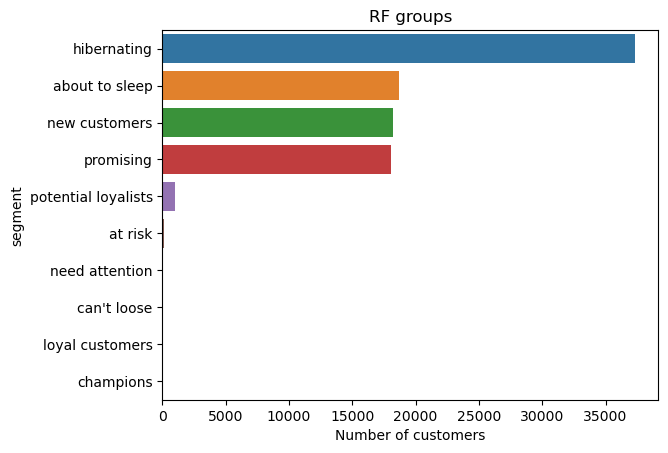

In [234]:
ax = sns.barplot(data=rfm_groups, x='count_customers', y='segment')
ax.set(title='RF groups', xlabel='Number of customers')

Около 2/5 пользователей покупали недавно, но нечасто(promising и new customers). Нужно попытаться привести их к повторным покупкам. Остальная часть пользователей за редким исключением покупали давно и нечасто, стоит напомнить им о существовании магазина купонами или скидками.